In [4]:
# !pip install --upgrade nipype

In [5]:
# import the necessary packages 
from nipype.interfaces import spm
from nipype import Workflow, Node, MapNode, JoinNode
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces import fsl
import os

In [6]:
##### USER's INPUTS ##### adjust this to run on your own data 

raw_dir = '/data' # path to raw data location 
experiment_dir = '/output' # base path for outputs 
workflow_name = 'spm_preproc' #set a name for your workflow, you can run the same workflow many times and store the corresponding results in different folders (folder name = workflow name)

output_dir = f'datasink/{workflow_name}' # specific path for output, here we use the name "datasink" - 
                                         # as the name of the method DataSink - more about it later' 

subject_list = ['01', '06'] #list of subjects to run preprocess on
                            #it's recommended to run on only one subject first to avoide wasting resource while not knowing if the script work properly.
                            #you can always add more participants in this list and rerun everything
                            #if you don't make manual changes in the folders containing outputs, nipype should be able to detect which prerocessing steps or subjects have been processed. 
                            #however this automatic detection does not always work well. If you recognize something unusual, you can clean the output folder or rerun the workflow under other workflow name

task_list = ['emodet'] #list of all task that have been done, nipype will run the workflow on each task as long as we set up the workflow correctly. More to come. 

your_ref_slice = "x" # choose a reference slice for slice_timing. It must be integer that show index of the slice you chose to be reference slice
                     # if it is set to 'x' as now, I set it up so that the middle slice is chosen as the reference slice 
                     # or in case of multiband sequence, it's set to number of slice // multiband factor 

# Smoothing widths to apply
fwhm = [4, 8] # set full width half maximum for smoothing, here I try to do 2 different smoothing process to compare which should me better

In [7]:
##### MAIN WORKFLOW #####

'''
In the following steps, I set up a workflow with nodes representing preprocessing steps. 
This cell contain only preprocessing steps that actually make changes to the data. 
'''

### 1. skip dummy scans ###
extract_roi = Node(fsl.ExtractROI(t_min=5, t_size=-1, output_type='NIFTI'), name='extract_roi')

### 2. slice timing ###
slice_timing = Node(spm.SliceTiming(), name='slice_timing')

### 3. motion correction ###
realign = Node(spm.Realign(), name="motion_correction")
realign.inputs.register_to_mean = True #realign every image to mean image 
realign.inputs.jobtype = "estwrite" #job = Estimate and write in SPM GUI 

### 4. coregistration ###
coreg = Node(spm.Coregister(), name='coregistration')

### 5. segmentation ###
segmentation = Node(spm.Segment(), name='segmentation')
segmentation.inputs.affine_regularization = 'mni' #choose template to realign anat img. 
segmentation.inputs.save_bias_corrected = True #save bias corrected image 

### 6. normalization ###
normalization =  Node(spm.Normalize12(), name='normalization')
normalization.inputs.affine_regularization_type = 'mni' #choose template for normalization 

### 7. smoothing ###
smooth = Node(spm.Smooth(), name='smooth')
smooth.iterables = ("fwhm", fwhm) #tell the workflow to do this step twice with different input values for fwhm 

In [8]:
##### SPECIFY INPUT AND OUTPUT STREAM #####

'''
In this cell, a bunch of more nodes are defined. They do not interfere with the data. 
They serve other purposes like finding the data, organize outputs, etc. 
'''

### iterate over subject names and taks ### this tels the workflow to run for many subjects and tasks. 
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']), name='infosource')
infosource.iterables = [('subject_id', subject_list),
                       ('task_name', task_list)]

### select files ### 
# this gives the workflow a naming pattern so that it can search automatically for all data
# if your data does not have a naming pattern, please consider having a naming convention. 
                
func_file = os.path.join('sub-{subject_id}', 'func', 'sub-{subject_id}_task-{task_name}_bold.nii.gz')
anat_file = os.path.join('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii')
task_info = os.path.join('sub-{subject_id}', 'func', 'sub-{subject_id}_task-{task_name}_bold.json')

# after defining the name pattern, we put it all in a dictionary since the node can only take input in dictionary form 
templates = {'func': func_file,
            'anat': anat_file, 
            'task_info': task_info}

select_files = Node(SelectFiles(templates, base_directory=raw_dir), name='selectfiles') #base_dir: where to find all data 
                                                                                        #templates: what do those data's names look like 

### extract task information ### slice timing require many inputs regarding the task, here is where we extract that info. 

def extract_task_info(json_file_path, ref_slice):
    
    #import task information file 
    import json
    with open(json_file_path, 'rt') as fp:
        task_info = json.load(fp)
    
    # find number of slice, TR, and slice order 
    num_slice = task_info['dcmmeta_shape'][2]
    TR = task_info['RepetitionTime']
    slice_order = [val*1000 for val in task_info['SliceTiming']] #originally in second, turn to millisecond
    
    # use reference slice from USER'S INPUT if given, otherwise take middle slice while considering multiband sequence 
    if isinstance(ref_slice, str):
        if 'MultibandAccelerationFactor' in task_info.keys():
            ref_slice = num_slice // (2*task_info['MultibandAccelerationFactor'])
            TA = 0
        else:
            ref_slice = num_slice // 2
            TA = TR-(TR/num_slice)
    else:
        TA = TR-(TR/num_slice)
    
    ref_slice_ms = slice_order[ref_slice]
    
    return num_slice, TR, TA, slice_order, ref_slice_ms

# put the function for extract task information data into a node 
extract_task_info_node = Node(interface=Function(input_names=['json_file_path', 'ref_slice'],
                                                    output_names=['num_slice', 'TR', 'TA', 'slice_order', 'ref_slice_ms'],
                                                    function=extract_task_info),
                                  name='extract_task_info_node')
extract_task_info_node.inputs.ref_slice = your_ref_slice

### creates output folder for important outputs and named them neatly ###
datasink = Node(DataSink(base_directory=experiment_dir, 
                        container=output_dir),
               name = 'datasink')

substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ('_fwhm_', 'fwhm-')
                 ]

subjFolders = [(f'fwhm-{f}/', f'fwhm-{f}') for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [9]:
##### SPECIFY WORKFLOW ##### 

'''
After defining all the nodes, here is where I connect them. In other words, to put them into the order that I want the data to be processed in
for a visualisation, please run the next two cells
'''

# create workflow 
spm_preproc = Workflow(name=workflow_name)
spm_preproc.config['execution'] = {'stop_on_first_crash': 'True',
                                  'crashfile_format': 'txt'}
spm_preproc.base_dir = experiment_dir

# connect node to the workflow and to each other
# in each () you first see names of two nodes that are supposed to connect to each other
# the rest in the () defind which information get passed from node 1 to node 2
# for every step that you get meaningful data output and want to inspect them later, connect them to datasink

spm_preproc.connect([
    # choose file
    (infosource, select_files, [('subject_id', 'subject_id'),
                            ('task_name', 'task_name')]),
    # extract roi
    (select_files, extract_roi, [('func', 'in_file')]),
    (extract_roi, datasink, [('roi_file', '@roi')]),
    
    #slice timing
    (select_files, extract_task_info_node, [('task_info', 'json_file_path')]),
    (extract_task_info_node, slice_timing, [('num_slice', 'num_slices'),
                                           ('TR', 'time_repetition'),
                                           ('TA', 'time_acquisition'),
                                           ('slice_order', 'slice_order'),
                                           ('ref_slice_ms', 'ref_slice')]),
    (extract_roi, slice_timing, [('roi_file', 'in_files')]),
    (slice_timing, datasink, [('timecorrected_files', '@slice_timing')]),
    
    # realign
    (slice_timing, realign, [('timecorrected_files', 'in_files')]),
    (realign, datasink, [('realigned_files', '@realign'),
                         ('realignment_parameters', '@realigned_par'),
                         ('mean_image', '@mean_img')]),
    
    # coregistration
    (select_files, coreg, [('anat', 'source')]),
    (realign, coreg, [('mean_image', 'target')]),
    (coreg, datasink, [('coregistered_source', '@coregistration')]),
    
    # segmentation
    (coreg, segmentation, [('coregistered_source', 'data')]),
    (segmentation, datasink, [('bias_corrected_image', '@bias_corrected')]),
    
    # normalization
    (segmentation, normalization, [('bias_corrected_image', 'image_to_align')]),
    (realign, normalization, [('realigned_files', 'apply_to_files')]),
    (normalization, datasink, [('normalized_image', '@normalized_image'),
                               ('normalized_files', '@normalized_files')
                              ]),
    
    #smooth
    (normalization, smooth, [('normalized_files', 'in_files')]),
    (smooth, datasink, [('smoothed_files', '@smooth')])
])

240922-10:11:00,432 nipype.workflow INFO:
	 Generated workflow graph: /output/spm_preproc1/graph.png (graph2use=flat, simple_form=True).


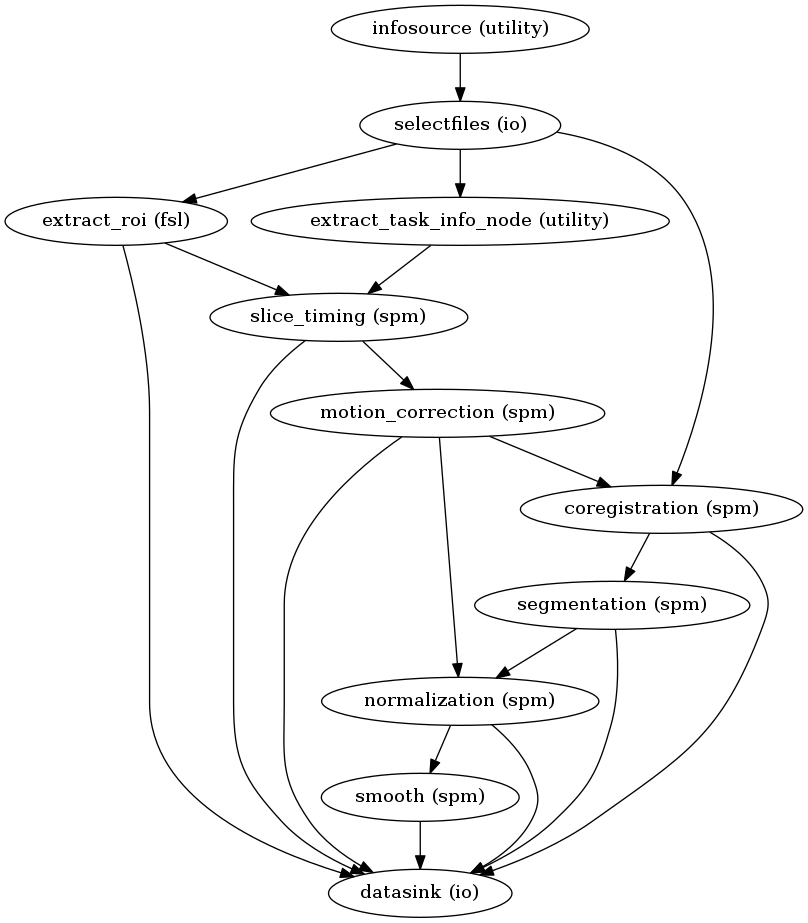

In [10]:
##### VISUALIZE WORKFLOW ##### #HERE 
spm_preproc.write_graph(graph2use='flat', format='png', simple_form=True)

from IPython.display import Image
Image(filename=os.path.join(spm_preproc.base_dir, workflow_name, 'graph.png'))

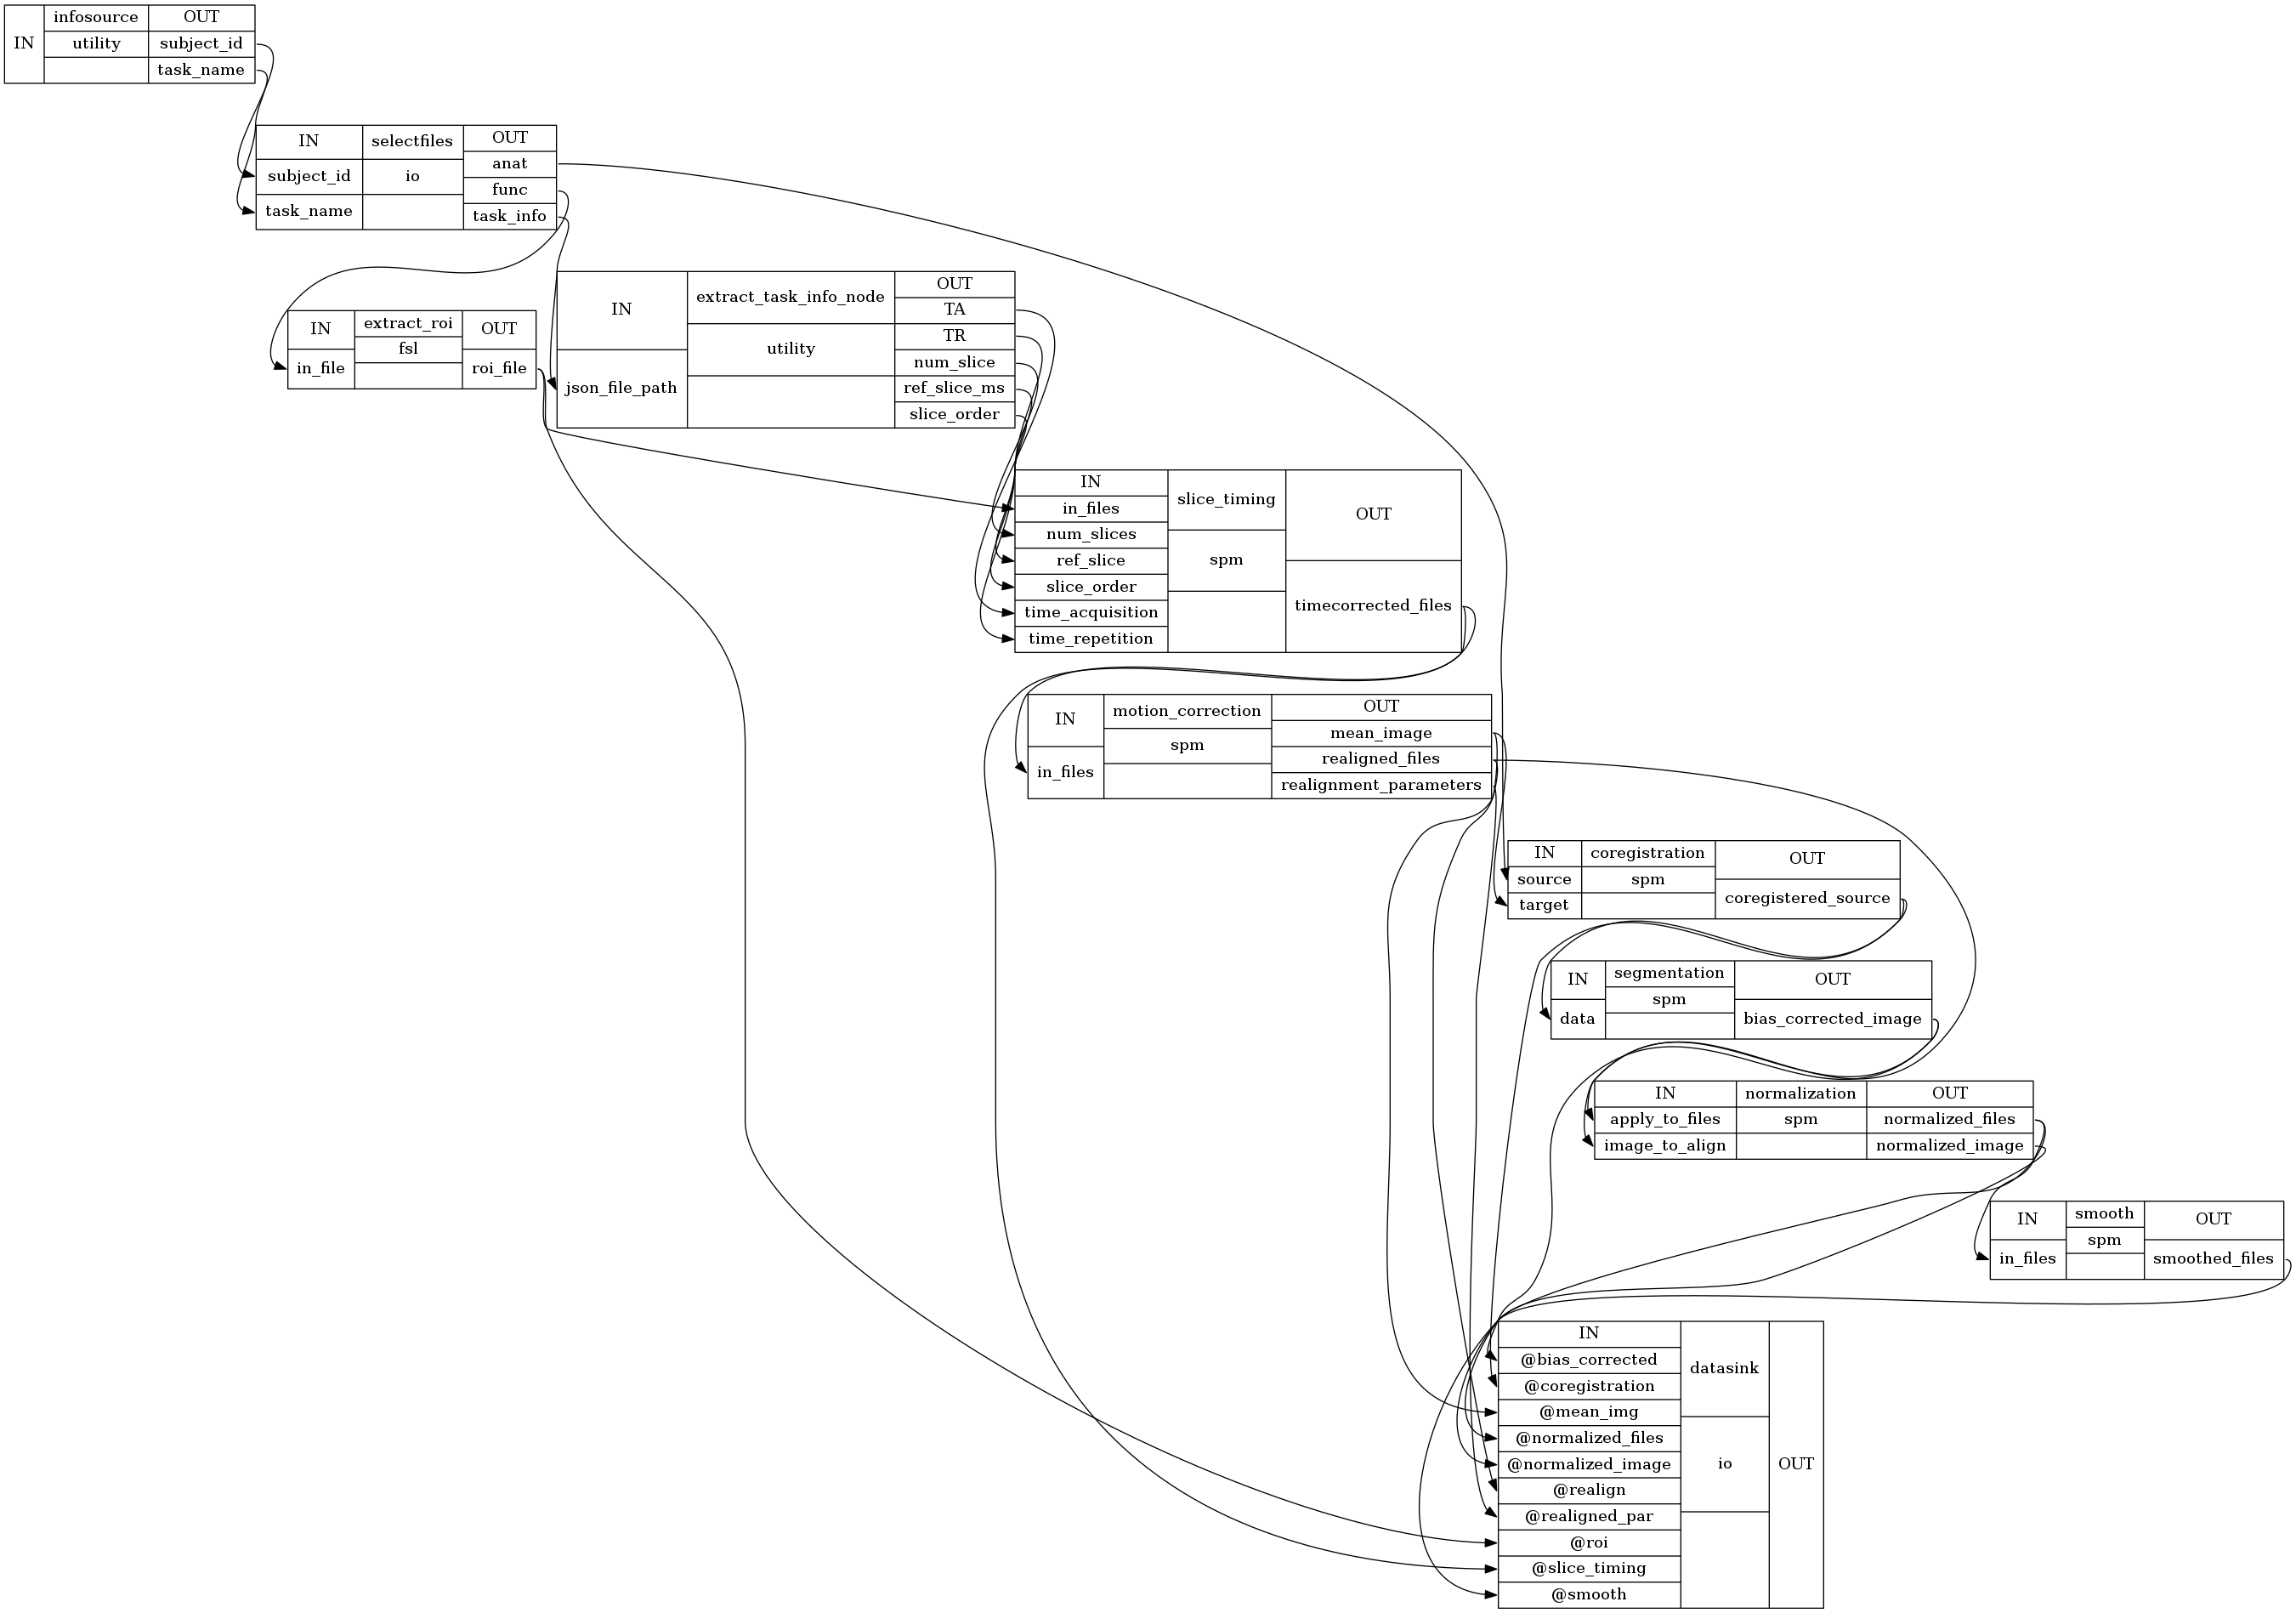

In [8]:
Image(filename=os.path.join(spm_preproc.base_dir, workflow_name, 'graph_detailed.png'))

In [9]:
##### RUN WORKFLOW #####
spm_preproc.run('MultiProc', plugin_args={'n_procs':4})

240522-20:35:25,851 nipype.workflow INFO:
	 Workflow spm_preproc1 settings: ['check', 'execution', 'logging', 'monitoring']
240522-20:35:25,933 nipype.workflow INFO:
	 Running in parallel.
240522-20:35:25,949 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 6.03/6.03, Free processors: 4/4.
240522-20:35:26,104 nipype.workflow INFO:
	 [Node] Setting-up "spm_preproc1.selectfiles" in "/output/spm_preproc1/_subject_id_06_task_name_emodet/selectfiles".240522-20:35:26,106 nipype.workflow INFO:
	 [Node] Setting-up "spm_preproc1.selectfiles" in "/output/spm_preproc1/_subject_id_01_task_name_emodet/selectfiles".

240522-20:35:26,194 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240522-20:35:26,197 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240522-20:35:26,205 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.002262s.
240522-20:35:26,211 nipype.wor

	 sub: /output/datasink/spm_preproc1/_subject_id_01_task_name_emodet/asub-01_task-emodet_bold_roi.nii -> /output/datasink/spm_preproc1/sub-01/task-emodet/asub-01_task-emodet_bold_roi.nii
240522-20:56:15,351 nipype.interface INFO:
	 sub: /output/datasink/spm_preproc1/_subject_id_01_task_name_emodet/rasub-01_task-emodet_bold_roi.nii -> /output/datasink/spm_preproc1/sub-01/task-emodet/rasub-01_task-emodet_bold_roi.nii
240522-20:56:15,356 nipype.interface INFO:
	 sub: /output/datasink/spm_preproc1/_subject_id_01_task_name_emodet/rp_asub-01_task-emodet_bold_roi.txt -> /output/datasink/spm_preproc1/sub-01/task-emodet/rp_asub-01_task-emodet_bold_roi.txt
240522-20:56:15,359 nipype.interface INFO:
	 sub: /output/datasink/spm_preproc1/_subject_id_01_task_name_emodet/meanasub-01_task-emodet_bold_roi.nii -> /output/datasink/spm_preproc1/sub-01/task-emodet/meanasub-01_task-emodet_bold_roi.nii
240522-20:56:15,363 nipype.interface INFO:
	 sub: /output/datasink/spm_preproc1/_subject_id_01_task_name_em

In [10]:
!tree /output/datasink

/output/datasink
├── spm_preproc
│   ├── sub-01
│   │   └── task-emodet
│   │       ├── asub-01_task-emodet_bold_roi.nii
│   │       ├── meanasub-01_task-emodet_bold_roi.nii
│   │       ├── mrsub-01_T1w.nii
│   │       ├── rasub-01_task-emodet_bold_roi.nii
│   │       ├── rp_asub-01_task-emodet_bold_roi.txt
│   │       ├── rsub-01_T1w.nii
│   │       ├── sub-01_task-emodet_bold_roi.nii
│   │       ├── wmrsub-01_T1w.nii
│   │       └── wrasub-01_task-emodet_bold_roi.nii
│   └── sub-06
│       └── task-emodet
│           ├── asub-06_task-emodet_bold_roi.nii
│           ├── meanasub-06_task-emodet_bold_roi.nii
│           ├── mrsub-06_T1w.nii
│           ├── rasub-06_task-emodet_bold_roi.nii
│           ├── rp_asub-06_task-emodet_bold_roi.txt
│           ├── rsub-06_T1w.nii
│           ├── sub-06_task-emodet_bold_roi.nii
│           ├── wmrsub-06_T1w.nii
│           └── wrasub-06_task-emodet_bold_roi.nii
└── spm_preproc1
    ├── sub-01
    │   └── task-emodet
    │       ├── asub-01_task-

# Test Area


In [3]:
#test
import json
import os
json_file_path = os.path.join(raw_dir,'sub-06', 'func', 'sub-06_task-emodet_bold.json')
with open(json_file_path, 'rt') as fp:
    task_info = json.load(fp)

num_slice = task_info['dcmmeta_shape'][2]
TR = task_info['RepetitionTime']
slice_order = [val*1000 for val in task_info['SliceTiming']] #originally in second, turn to millisecond


if 'MultibandAccelerationFactor' in task_info.keys():
    ref_slice = num_slice // (2*task_info['MultibandAccelerationFactor'])
    TA = 0
else:
    ref_slice = num_slice // 2
    TA = TR-(TR/num_slice)